In [1]:
# ipynb形式のライブラリのインポート
%run ./lib/lib.ipynb


plotBase = list(range(20))
plotX = returnListForBranchModel(inputList=plotBase, branchIndex=13, a=2, b=3)
plotY = returnListForBranchModel(inputList=plotBase, branchIndex=16, a=4, b=5)
plotX = np.array(plotX)
plotY = np.array(plotY)
plotZ = plotX+plotY

# TODO:関数コール回数が同じだが、2変数が異なる変数かつそういったものが多数ある場合が分岐線

print(f"plotBase={plotBase}\nplotX={plotX}\nplotY={plotY}")

plotBase=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
plotX=[ 3  5  7  9 11 13 15 17 19 21 23 25 27 29 29 29 29 29 29 29]
plotY=[ 5  9 13 17 21 25 29 33 37 41 45 49 53 57 61 65 69 69 69 69]


In [2]:
# ２点間を繋ぐ直線を返す関数
# 引数p1, p2 は [x, y, z] のような3つの要素で構成されるリスト
def returnStraightLineDataBetween2Points(p1=[], p2=[]):
    if (len(p1) == 0 or len(p2) == 0):
        warnings.warn("引数が条件（要素数3のリストx2）を満たしていません")
        return(-1)

    ax = p1[0]
    ay = p1[1]
    az = p1[2]

    bx = p2[0]
    by = p2[1]
    bz = p2[2]

    iterList = np.arange(0, 1.01, 0.01)

    retX = []
    retY = []
    retZ = []

    for t in iterList:
        x = (1-t)*ax + t*bx
        y = (1-t)*ay + t*by
        z = (1-t)*az + t*bz

        retX.append(x)
        retY.append(y)
        retZ.append(z)

    returnDict = {"x": retX, "y": retY, "z": retZ}

    return(returnDict)

# returnStraightLineDataBetween2Points()で返されたデータから、直線の切片と係数を返す関数
# 引数はreturnStraightLineDataBetween2Points()返り値


def returnCoefAndIntercept(inputDict):
    lr = LinearRegression()
    x = inputDict["x"]
    y = inputDict["y"]
    expDF = pd.DataFrame({"x": x})
    resDF = pd.DataFrame({"y": y})
    lr.fit(expDF, resDF)
    coef_ = lr.coef_[0]
    intercept_ = lr.intercept_
    returnDict = {"coef_": coef_, "intercept_": intercept_}
    return(returnDict)

In [3]:
# プロットするためのデータを作成する

plotZero = [0]*len(plotBase)
dataset01 = pd.DataFrame({"X": plotBase, "Y": plotZero, "Z": plotX})
dataset02 = pd.DataFrame({"X": plotZero, "Y": plotBase, "Z": plotY})

xDataSet01 = dataset01["X"].tolist()
zDataSet01 = dataset01["Z"].tolist()
yDataSet02 = dataset02["Y"].tolist()
zDataSet02 = dataset02["Z"].tolist()

branchIndexInDataSet01 = returnBranchIndexOfList(
    inputListX=xDataSet01, inputListY=zDataSet01)
branchIndexInDataSet02 = returnBranchIndexOfList(
    inputListX=yDataSet02, inputListY=zDataSet02)

p1x = dataset01["X"][branchIndexInDataSet01]
p1y = dataset01["Y"][branchIndexInDataSet01]
p1z = dataset01["Z"][branchIndexInDataSet01]

p2x = dataset02["X"][branchIndexInDataSet02]
p2y = dataset02["Y"][branchIndexInDataSet02]
p2z = dataset02["Z"][branchIndexInDataSet02]

splitLine = returnStraightLineDataBetween2Points(
    p1=[p1x, p1y, p1z], p2=[p2x, p2y, p2z])
splitLineDict = returnCoefAndIntercept(splitLine)

In [4]:
splitLineDict

{'coef_': array([-1.23076923]), 'intercept_': array([16.])}

In [5]:
# TODO:モデル作成とそれに関連する処理

# 1. 分岐点の前後にデータを分割
# データ1
data01BeforeBranchPoint = {"X": dataset01["X"][:branchIndexInDataSet01], "Y": dataset01["Y"]
                           [:branchIndexInDataSet01], "Z": dataset01["Z"][:branchIndexInDataSet01]}
data01AfterBranchPoint = {"X": dataset01["X"][branchIndexInDataSet01:], "Y": dataset01["Y"]
                          [branchIndexInDataSet01:], "Z": dataset01["Z"][branchIndexInDataSet01:]}
DF01BeforeBranchPoint = pd.DataFrame(data01BeforeBranchPoint)
DF01AfterBranchPoint = pd.DataFrame(data01AfterBranchPoint)
# データ2
data02BeforeBranchPoint = {"X": dataset02["X"][:branchIndexInDataSet02], "Y": dataset02["Y"]
                           [:branchIndexInDataSet02], "Z": dataset02["Z"][:branchIndexInDataSet02]}
data02AfterBranchPoint = {"X": dataset02["X"][branchIndexInDataSet02:], "Y": dataset02["Y"]
                          [branchIndexInDataSet02:], "Z": dataset02["Z"][branchIndexInDataSet02:]}
DF02BeforeBranchPoint = pd.DataFrame(data02BeforeBranchPoint)
DF02AfterBranchPoint = pd.DataFrame(data02AfterBranchPoint)

# 2. 分岐点の前後で、それぞれ異なるモデルを作成
# 2-1. 学習用データとするために分岐点前のデータと、分岐点後のデータをそれぞれ縦に結合する
dataBefore = pd.concat([DF01BeforeBranchPoint, DF02BeforeBranchPoint], axis=0)
dataAfter = pd.concat([DF01AfterBranchPoint, DF02AfterBranchPoint], axis=0)
# 2-2. 各データを説明変数と目的変数に分ける
DFBeforeExpVar = dataBefore[["X", "Y"]]
DFBeforeResVar = dataBefore[["Z"]]
DFAfterExpVar = dataAfter[["X", "Y"]]
DFAfterResVar = dataAfter[["Z"]]
# 2-2. 学習を行う
lr1 = LinearRegression()
lr2 = LinearRegression()
# 2-3. 分割されたデータのそれぞれにあった、fit()を実施する
lr1.fit(DFBeforeExpVar, DFBeforeResVar)
lr2.fit(DFAfterExpVar, DFAfterResVar)

# 3. 3Dプロットされることになる、すべての整数の点に対して予測・プロットを行う(x:0-18, y:0-18)
ExpectPointX = []
ExpectPointY = []
start = 0.4
stop  = 19
step  = 1.0
for i in np.arange(start, stop, step):
    for j in np.arange(start, stop, step):
        ExpectPointX.append(i)
        ExpectPointY.append(j)

# 3-1. 分岐線の coef_, intercept_ を使って、データを分割する
coef_ = splitLineDict["coef_"]
intercept_ = splitLineDict["intercept_"]
expectPointXBefore = []
expectPointXAfter = []
expectPointYBefore = []
expectPointYAfter = []
for x, y in zip(ExpectPointX, ExpectPointY):
    if (y <= coef_*x + intercept_):
        expectPointXBefore.append(x)
        expectPointYBefore.append(y)
    else:
        expectPointXAfter.append(x)
        expectPointYAfter.append(y)
# 3-2. 予測を行う
datumForPlot = {"x": [], "y": [], "z": []}
for x, y in zip(expectPointXBefore, expectPointYBefore):
    DFForPredict = pd.DataFrame({"X": [x], "Y": [y]})
    result = lr1.predict(DFForPredict)
    datumForPlot["x"].append(x)
    datumForPlot["y"].append(y)
    datumForPlot["z"].append(result)
for x, y in zip(expectPointXAfter, expectPointYAfter):
    DFForPredict = pd.DataFrame({"X": [x], "Y": [y]})
    result = lr2.predict(DFForPredict)
    datumForPlot["x"].append(x)
    datumForPlot["y"].append(y)
    datumForPlot["z"].append(result)

<ipython-input-6-1de298da403d>:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


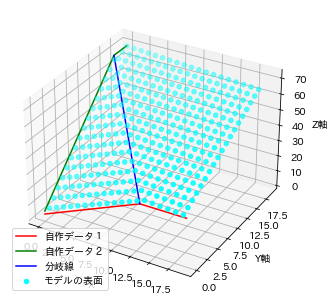

In [6]:
fig = plt.figure()
ax = Axes3D(fig)

ax.set_xlabel("X")
ax.set_ylabel("Y軸")
ax.set_zlabel("Z軸")

ax.plot(plotBase, plotZero, plotX, color="red", label="自作データ１")
ax.plot(plotZero, plotBase, plotY, color="green", label="自作データ２")
ax.plot(splitLine["x"], splitLine["y"], splitLine["z"], color="blue", label="分岐線")
# 3-3. プロットを行う
ax.scatter(datumForPlot["x"], datumForPlot["y"], datumForPlot["z"], color="cyan", label="モデルの表面")

ax.legend()

In [7]:
class ModelBranchForMultipleRegression(ModelBaseForMultipleRegression):
    # 線形飽和モデル（重回帰分析）

    def transformDataForModel(self, inputDF):
        # inputDFで与えられたデータをモデルに適した形に変形する
        return(inputDF)

    def setUpDataBeforeCalcLr(self):
        # 説明変数・目的変数を変換する関数
        # モデル構築用データ
        self.dataXForPredict = self.transformDataForModel(
            self.rawExplanaoryVariable)
        self.dataTForPredict = self.transformDataForModel(
            self.rawResponseVariable)
        # テスト用データ
        self.dataXForTest = self.transformDataForModel(
            self.rawExplanaoryVariableForTest)
        self.dataTForTest = self.transformDataForModel(
            self.rawResponseVariableForTest)

    def calcLr(self):
        # 実際にモデルを構築する
        self.lr = LinearRegression()
        self.lr.fit(self.dataXForPredict, self.dataTForPredict)

    def predict(self, inputDF):
        # inputDFのデータから構築されたモデルを使って予測を行う

        # inputDFから説明変数データのみを取得
        inputDFOnlyExplanatoryVariableColumn = inputDF[self.explanatoryVariableColumnNames]
        # 予測を実行
        result = self.lr.predict(inputDFOnlyExplanatoryVariableColumn)

        return(result)

# 説明変数が2つの分岐モデルを実装するにあたってのテストなど

1. ~\[X, Y, Z\] == \[0, Y, Z\], \[X, 0, Z\] を満たすデータ群を抽出~ -> 変数 `dataset01`, `dataset02` 
2. ~抽出した2つのデータ群から分岐点を抽出~ -> 変数 `branchIndexInDataSet01`, `branchIndexInDataSet01` 
3. ~抽出した分岐点を繋ぐ直線を定義~ -> 変数 `splitLine`
4. ~データ群を定義した直線で2つに分割~ -> プロットした図の通り
5. 分割された2平面ごとにモデルを構築

In [8]:
branchIndexInDataSet01

13

In [9]:
branchIndexInDataSet02

16

In [10]:
pointA = dataset01.iloc[branchIndexInDataSet01]
p1 = [pointA["X"], pointA["Y"], pointA["Z"]]
print(pointA)
print(p1)

X    13
Y     0
Z    29
Name: 13, dtype: int64
[13, 0, 29]


In [11]:
pointB = dataset02.iloc[branchIndexInDataSet02]
p2 = [pointB["X"], pointB["Y"], pointB["Z"]]
print(pointB)
print(p2)

X     0
Y    16
Z    69
Name: 16, dtype: int64
[0, 16, 69]


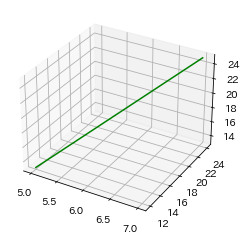

In [12]:
p1 = [5, 12, 13]
p2 = [7, 24, 25]
lineDataDict = returnStraightLineDataBetween2Points(p1=p1, p2=p2)

fig = plt.figure()
ax = plt.axes(projection='3d')
x = lineDataDict["x"]
y = lineDataDict["y"]
z = lineDataDict["z"]

ax.plot3D(x, y, z, 'green')
ax.plot3D(p1[0], p1[1], p1[2])
ax.plot3D(p2[0], p2[1], p2[2])

# plotZero = [0]*len(plotBase)
# ax.scatter(plotBase, plotZero, plotX)
# ax.scatter(plotZero, plotBase, plotY)

plt.show()

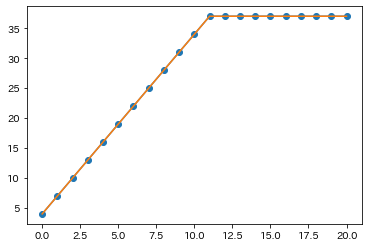

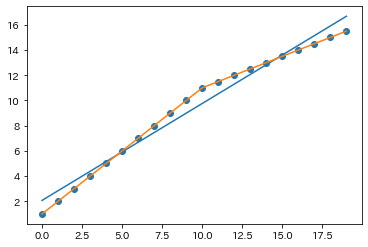

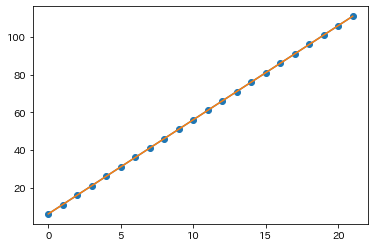

In [13]:
# プロジェクト別ゼミ用資料作成

# ipynb形式のライブラリのインポート
# %run ./lib/lib.ipynb

branchIndex = 11
dataBase1 = list(range(branchIndex))
dataBase2 = [branchIndex]*(21-11)
dataList1 = [3*x + 4 for x in dataBase1]
dataList2 = [3*x + 4 for x in dataBase2]
dataBase2 = list(range(11, 21))
dataListY = dataList1+dataList2
dataListX = dataBase1+dataBase2

# プロット
plt.figure()
plt.scatter(dataListX, dataListY)
# 分岐モデル
modelBranch = ModelBranch(trainX=dataListX, trainY=dataListY)
modelBranch.calcLr()
predictedY = modelBranch.predict(dataListX)
plt.plot(dataListX, predictedY)
# 分岐モデル2
modelBranch2 = ModelBranch2(trainX=dataListX, trainY=dataListY)
modelBranch2.calcLr()
predictedY = modelBranch2.predict(dataListX)
plt.plot(dataListX, predictedY)

# データ２：分岐点で異なる線形モデルに変化
branchIndex = 10
dataBase1 = list(range(branchIndex))
dataBase2 = list(range(branchIndex, 20))
dataList1 = [x + 1 for x in dataBase1]
dataList2 = [0.5*x + 6 for x in dataBase2]
dataListY = dataList1+dataList2
dataListX = dataBase1+dataBase2

# プロット
plt.figure()
plt.scatter(dataListX, dataListY)
# 分岐モデル
modelBranch = ModelBranch(trainX=dataListX, trainY=dataListY)
modelBranch.calcLr()
predictedY = modelBranch.predict(dataListX)
plt.plot(dataListX, predictedY)
# 分岐モデル2
modelBranch2 = ModelBranch2(trainX=dataListX, trainY=dataListY)
modelBranch2.calcLr()
predictedY = modelBranch2.predict(dataListX)
plt.plot(dataListX, predictedY)


# データ３：分岐点無し
branchIndex = 22
dataBase1 = list(range(branchIndex))
dataListY = [5*x + 6 for x in dataBase1]
dataListX = dataBase1


# プロット
plt.figure()
plt.scatter(dataListX, dataListY)
# 分岐モデル
modelBranch = ModelBranch(trainX=dataListX, trainY=dataListY)
modelBranch.calcLr()
predictedY = modelBranch.predict(dataListX)
plt.plot(dataListX, predictedY)
# 分岐モデル2
modelBranch2 = ModelBranch2(trainX=dataListX, trainY=dataListY)
modelBranch2.calcLr()
predictedY = modelBranch2.predict(dataListX)
plt.plot(dataListX, predictedY)

### プロジェクト別ゼミ用の表を作成する

In [14]:


benchmarkNames = ["cg", "ep", "ft", "is", "lu", "mg"]
# classes = ["A", "B", "C", "D"]
classes = ["B"]
processes = [2, 4, 8, 16, 32, 64, 128, 256]
targetIndex = -1
csvDirPath = "./csv_files/"
modelNames = ["ModelBranch", "ModelIp", "ModelLog", "ModelLin"]
modelNames2 = ["ModelBranch2", "ModelIp", "ModelLog", "ModelLin"]

dfByDatumCG = returnDFSummarizedData(
    benchmarkNames=benchmarkNames, classes=classes, processes=processes, targetIndex=targetIndex, csvDirPath=csvDirPath, modelNames=modelNames)
dfByDatumCG2 = returnDFSummarizedData(
    benchmarkNames=benchmarkNames, classes=classes, processes=processes, targetIndex=targetIndex, csvDirPath=csvDirPath, modelNames=modelNames2)

dictForLatexTable = {}
dictForLatexTable2 = {}
numOfData = 0
numOfData2 = 0

for benchmarkName in benchmarkNames:
    dictForLatexTable[benchmarkName] = dfByDatumCG[dfByDatumCG["benchmarkName"] == benchmarkName]
    numOfData += len(
        dfByDatumCG[dfByDatumCG["benchmarkName"] == benchmarkName])
    dictForLatexTable2[benchmarkName] = dfByDatumCG2[dfByDatumCG2["benchmarkName"] == benchmarkName]
    numOfData2 += len(
        dfByDatumCG2[dfByDatumCG2["benchmarkName"] == benchmarkName])


listForDF = []
for benchmarkName in benchmarkNames:
    listForDF.append(returnSeriesOfDatumPerBenchmark(
        inputDF=dictForLatexTable[benchmarkName], modelNames=modelNames))
DF = pd.DataFrame(listForDF)
DF = DF.sort_values("benchmarkName")
columnNameList = ["ベンチマーク名(関数の個数)", "線形飽和モデル", "反比例モデル", "対数モデル", "線形モデル"]
DF.columns = columnNameList
print(DF.to_latex(index=False))

listForDF2 = []
for benchmarkName in benchmarkNames:
    listForDF2.append(returnSeriesOfDatumPerBenchmark(
        inputDF=dictForLatexTable2[benchmarkName], modelNames=modelNames2))
DF = pd.DataFrame(listForDF2)
DF = DF.sort_values("benchmarkName")
columnNameList = ["ベンチマーク名(関数の個数)", "線形飽和モデル", "反比例モデル", "対数モデル", "線形モデル"]
DF.columns = columnNameList
print(DF.to_latex(index=False))

\begin{tabular}{lllll}
\toprule
ベンチマーク名(関数の個数) &     線形飽和モデル &       反比例モデル &         対数モデル &        線形モデル \\
\midrule
        CG(22) & 18(0.0,0.0) &         0(-) & 13(11.7,11.7) &  69(0.0,0.0) \\
         EP(9) &        0(-) &         0(-) &          0(-) & 100(0.0,0.0) \\
        FT(32) &        0(-) &   9(0.0,0.0) &          0(-) &  91(0.0,0.0) \\
        IS(21) &        0(-) &  19(0.0,0.0) &          0(-) &  81(0.0,0.0) \\
        LU(42) &        0(-) & 30(0.0,25.9) &          0(-) &  70(0.0,0.0) \\
        MG(30) &        0(-) &         0(-) &    3(0.5,0.5) &  97(0.0,3.4) \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
ベンチマーク名(関数の個数) &     線形飽和モデル &       反比例モデル &         対数モデル &        線形モデル \\
\midrule
        CG(22) & 18(0.0,0.0) &         0(-) & 13(11.7,11.7) &  69(0.0,0.0) \\
         EP(9) &        0(-) &         0(-) &          0(-) & 100(0.0,0.0) \\
        FT(32) &        0(-) &   9(0.0,0.0) &          0(-) &  91(0.0,0.0) \\
        IS(21) &        0(-) &  1

In [15]:
forInputDF = returnDFSummarizedData(
    benchmarkNames=["cg", "ep", "ft", "is", "lu", "mg"],
    classes=["B"],
    processes=[2, 4, 8, 16, 32, 64, 128, 256],
    targetIndex=-1,
    csvDirPath="./csv_files/",
    modelNames=["ModelBranch", "ModelIp", "ModelLog", "ModelLin"]
)

benchmarkNames = list(set(forInputDF["benchmarkName"].tolist()))
benchmarkNames.sort()
columnsNames = ["ベンチマーク名(関数の個数)", "MAPE(予測対象関数コール回数に対する)"]
listForRelativeErrorTable = []
for benchmarkName in benchmarkNames:
    forInputDFPerBenchmark = forInputDF[forInputDF["benchmarkName"]
                                        == benchmarkName]
    column1 = f"{benchmarkName.upper()}({len(forInputDFPerBenchmark)})"
    seriesOfMean = forInputDFPerBenchmark.mean()
    seriesOfMeanRelativeErrorRate = seriesOfMean["RelativeErrorRate"]
    column2 = int(seriesOfMeanRelativeErrorRate * 100) / 100
    listForRelativeErrorTable.append([column1, column2])
DFtoLatex = pd.DataFrame(listForRelativeErrorTable, columns=columnsNames)
print(DFtoLatex.to_latex(index=False))

forInputDF = returnDFSummarizedData(
    benchmarkNames=["cg", "ep", "ft", "is", "lu", "mg"],
    classes=["B"],
    processes=[2, 4, 8, 16, 32, 64, 128, 256],
    targetIndex=-1,
    csvDirPath="./csv_files/",
    modelNames=["ModelBranch2", "ModelIp", "ModelLog", "ModelLin"]
)

benchmarkNames = list(set(forInputDF["benchmarkName"].tolist()))
benchmarkNames.sort()
print(f"benchmarkNames={benchmarkNames}")
columnsNames = ["ベンチマーク名(関数の個数)", "MAPE(予測対象関数コール回数に対する)"]
listForRelativeErrorTable = []
for benchmarkName in benchmarkNames:
    forInputDFPerBenchmark = forInputDF[forInputDF["benchmarkName"]
                                        == benchmarkName]
    column1 = f"{benchmarkName.upper()}({len(forInputDFPerBenchmark)})"
    seriesOfMean = forInputDFPerBenchmark.mean()
    seriesOfMeanRelativeErrorRate = seriesOfMean["RelativeErrorRate"]
    column2 = int(seriesOfMeanRelativeErrorRate * 100) / 100
    listForRelativeErrorTable.append([column1, column2])
DFtoLatex = pd.DataFrame(listForRelativeErrorTable,
                         columns=columnsNames)
print(DFtoLatex.to_latex(index=False))

\begin{tabular}{lr}
\toprule
ベンチマーク名(関数の個数) &  MAPE(予測対象関数コール回数に対する) \\
\midrule
        CG(22) &                   1.65 \\
         EP(9) &                   0.00 \\
        FT(32) &                   0.00 \\
        IS(21) &                   0.00 \\
        LU(42) &                  22.45 \\
        MG(30) &                   3.09 \\
\bottomrule
\end{tabular}

benchmarkNames=['cg', 'ep', 'ft', 'is', 'lu', 'mg']
\begin{tabular}{lr}
\toprule
ベンチマーク名(関数の個数) &  MAPE(予測対象関数コール回数に対する) \\
\midrule
        CG(22) &                   1.65 \\
         EP(9) &                   0.00 \\
        FT(32) &                   0.00 \\
        IS(21) &                   0.00 \\
        LU(42) &                  22.45 \\
        MG(30) &                   3.09 \\
\bottomrule
\end{tabular}



In [16]:
DFtoLatex

,ベンチマーク名(関数の個数),MAPE(予測対象関数コール回数に対する)
0,CG(22),1.65
1,EP(9),0.00
2,FT(32),0.00
3,IS(21),0.00
4,LU(42),22.45
5,MG(30),3.09


# CGの生データを確認して、2変数モデルが実際に必要かどうかを確認する

<ipython-input-17-c03dbed08092>:15: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
<ipython-input-17-c03dbed08092>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


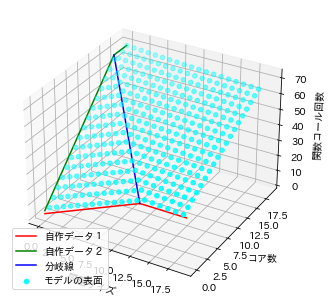

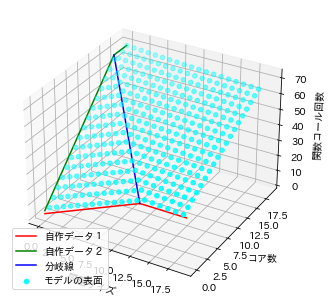

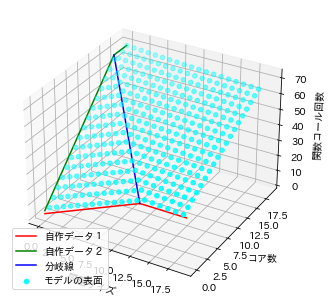

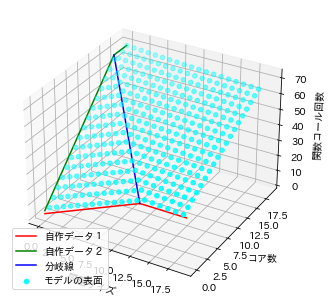

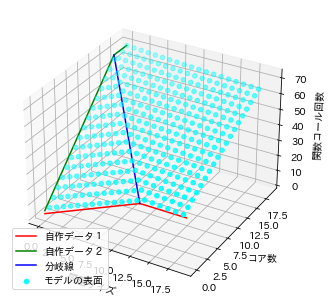

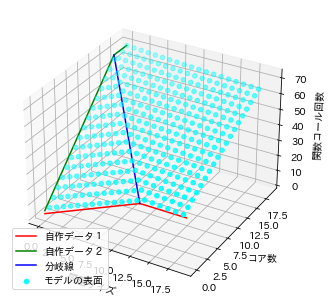

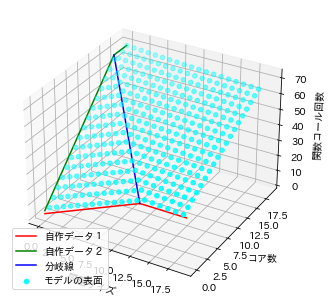

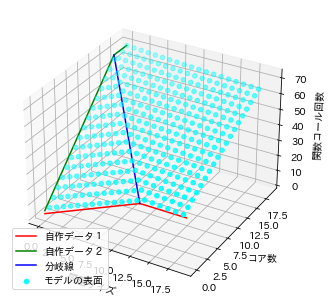

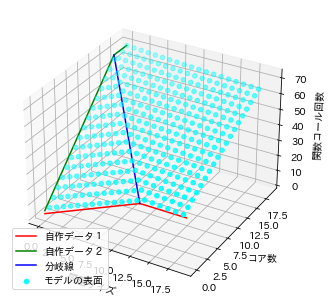

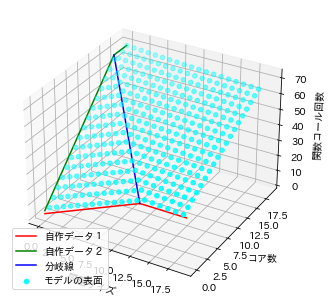

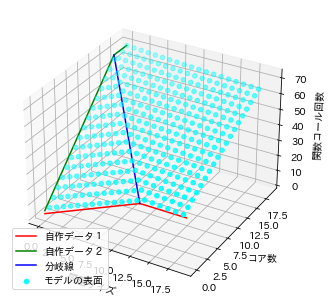

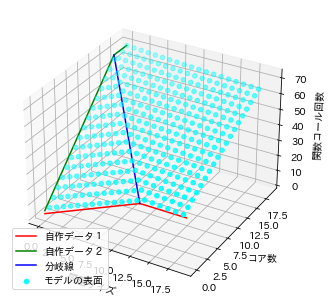

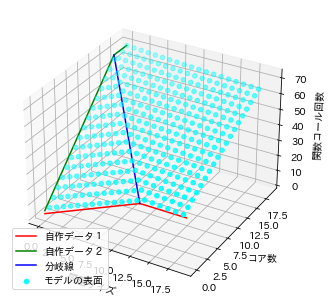

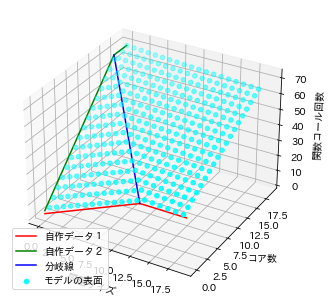

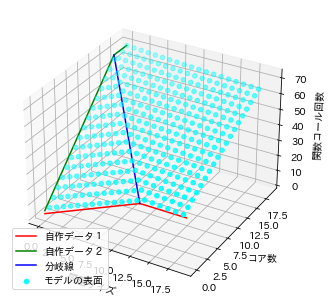

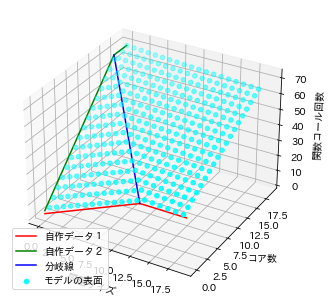

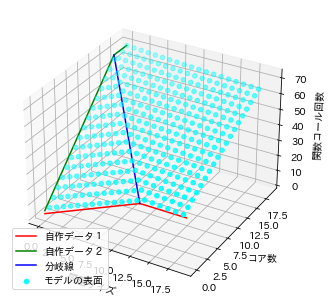

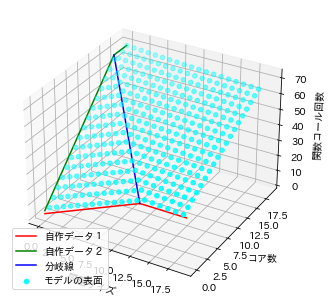

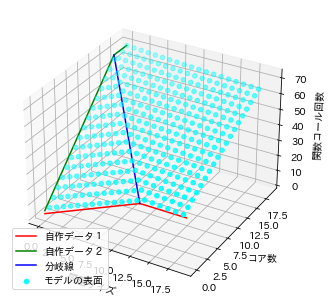

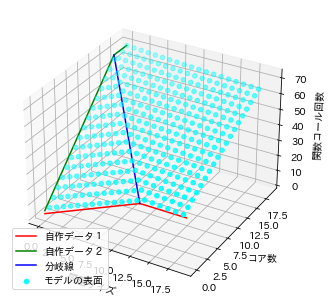

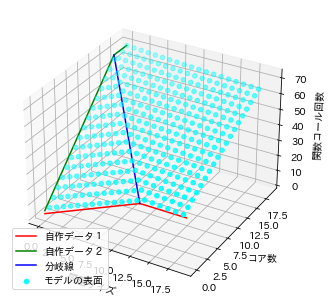

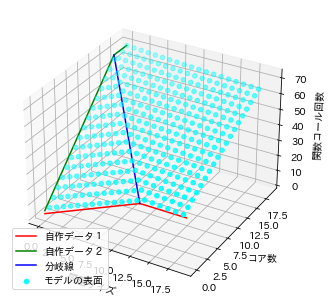

In [17]:
benchmarkNames = ["cg"]
classes = ["A", "B", "C", "D"]
processes = [2, 4, 8, 16, 32, 64, 128, 256]
csvDirPath = "./csv_files/"
modelNames = ["ModelBranch", "ModelIp", "ModelLog", "ModelLin"]
rawDataDF = returnCollectedExistingData(benchmarkNames=benchmarkNames, classes=classes, processes=processes, csvDirPath="./csv_files/")
functionNames = sorted(list(set(rawDataDF["functionName"].tolist())))
rawDataDF

for functionName in functionNames:
    functionCallCount = rawDataDF[rawDataDF["functionName"]==functionName]
#     print(functionCallCount)

    fig = plt.figure()
    ax = Axes3D(fig)

    ax.set_xlabel("問題サイズ")
    ax.set_ylabel("コア数")
    ax.set_zlabel("関数コール回数")

    ax.plot(plotBase, plotZero, plotX, color="red", label="自作データ１")
    ax.plot(plotZero, plotBase, plotY, color="green", label="自作データ２")
    ax.plot(splitLine["x"], splitLine["y"], splitLine["z"], color="blue", label="分岐線")
    # 3-3. プロットを行う
    ax.scatter(datumForPlot["x"], datumForPlot["y"], datumForPlot["z"], color="cyan", label="モデルの表面")
    ax.legend()

# TODO:プロットする

